In [57]:
import pandas as pd
import numpy as np
import random

# DataFrame Creation

In [58]:
SEED = 42 # answer to everything
# Don't really need reproducibility rn.
# np.random.seed(SEED)
# random.seed(SEED)

TRAIN_FRAC = 0.3
PUBLIC_LEADERBOARD_FRAC = 0.2
PRIVATE_LEADERBOARD_FRAC = 0.5
assert TRAIN_FRAC + PUBLIC_LEADERBOARD_FRAC + PRIVATE_LEADERBOARD_FRAC == 1, "Fractions must sum to 1"
N_TRAIN_SAMPLES = 10000
N_SAMPLES = int(N_TRAIN_SAMPLES // TRAIN_FRAC)
print(f"Total number of samples: {N_SAMPLES}")

PUBLIC_PRIVATE_SPLIT = 0.3 # Fraction of samples used for the public dataset
TEST_TRAIN_SPLIT = 0.2 # Fraction of samples used for the test set

ID_VARIABLE_NAME = "ID" # Name of the ID variable.
TARGET_VARIABLE_NAME = "y" # Name of the target variable.

INITIAL_NOISE = 0.1 # Previously was 0.3
FINAL_NOISE = 0.05 # Added to the final target

CAT_ERROR_PROB = 0.1 # Probability of categorical error
TRAIN_NAN_PROB = 0.08
PUBLIC_NAN_PROB = 0.12
PRIVATE_NAN_PROB = 0.15

DATA_DIR = "data"

Total number of samples: 33333


In [59]:
class cds:
    def __init__(self, weight: int) -> None:
        self.weight = weight
        
        # Nominal
        types = ['jut', 'kiv', 'tir', 'vel', 'qou']
        types_p = [0.2, 0.3, 0.2, 0.2, 0.1]
        type_col = np.random.choice(types, N_SAMPLES, p=types_p)

        # Ordinal
        matter = { # frequency, strength
            'corro': (6, 0),
            'corroyi': (5, 1),
            'sfer': (5, 2),
            'black corru': (3, 1),
            'corruskivi': (2, 10),
            'corrutir': (1, 10),
            'corrutir vel': (1, 12),
            'satik cyst': (5, 15),
            'pale corru': (0, 30),
        }
        matter_f_sum = sum(freq for freq, _ in matter.values())
        matter_p = [freq / matter_f_sum for freq, _ in matter.values()]
        matter_names = list(matter.keys())
        matter_col = np.random.choice(
            matter_names,
            N_SAMPLES,
            p=matter_p
        )

        # Ordinal
        mindspike_versions = {'tonga': 0, 'karbon': 1, 'silikon': 2, 'kristal': 3, 'nan': 4} # Replace 'nan' with an actual NaN later.
        mindspike_v_col = np.random.choice(
            list(mindspike_versions.keys()),
            N_SAMPLES,
            p=[0.1, 0.2, 0.2, 0.4, 0.1]
        )

        effect_matter = np.array([matter[m_name][1] for m_name in matter_col])
        effect_mindspike = np.array([mindspike_versions[m_name] for m_name in mindspike_v_col])
        y = effect_matter + effect_mindspike + np.random.normal(0, INITIAL_NOISE, N_SAMPLES)

        for i in range(N_SAMPLES):
            match type_col[i]:
                case 'jut':
                    y[i] *= 1.5
                case 'kiv':
                    y[i] *= 0.5
                case 'tir':
                    y[i] = 0
                case 'vel':
                    y[i] = np.sin(y[i])
                case 'qou':
                    y[i] *= 3

        min_y = y.min()
        max_y = y.max()
        if min_y == max_y:
            y = np.zeros_like(y)
        else:
            y = (y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X = pd.DataFrame({
            'type': type_col,
            'matter': matter_col,
            'mindspike': mindspike_v_col,
        })
        self.y = pd.Series(y, name='cat_y')

        # Replace 'nan' string in mindspike with actual NaN
        self.X['mindspike'] = self.X['mindspike'].replace('nan', np.nan)

        # Induce categorical errors
        n_rows = self.X.shape[0]
        n_cat_errors = int(n_rows * CAT_ERROR_PROB)

        # Randomly choose pairs of indices
        error_row_indices = np.random.choice(self.X.index, n_cat_errors, replace=True)

        for idx in error_row_indices:
            match np.random.choice(2):
                case 0:
                    self.X.at[idx, 'type'] = self.X.at[idx, 'type'] + 'skin'
                case 1:
                    self.X.at[idx, 'mindspike'] = 'ERROR'

In [60]:
from sklearn.datasets import (
    make_moons, make_circles, make_blobs, make_classification, make_hastie_10_2,
    make_friedman1, make_friedman2, make_friedman3, make_regression
)
#from sklearn.preprocessing import MinMaxScaler
from typing import Callable

class ds:
    def __init__(self, weight: float, name: str, generator: Callable[[], tuple[np.ndarray, np.ndarray]]):
        self.weight: float = weight
        self.name: str = name

        self.raw_X: np.ndarray
        self.raw_y: np.ndarray
        self.raw_X, self.raw_y = generator()

        min_y = self.raw_y.min()
        max_y = self.raw_y.max()
        if min_y == max_y:
            self.raw_y = np.zeros_like(self.raw_y)
        else:
            self.raw_y = (self.raw_y - min_y) / (max_y - min_y)  # Normalize y to [0, 1]

        self.X: pd.DataFrame = pd.DataFrame(
            self.raw_X,
            columns=[
                f"{self.name}_{i+1}" for i in range(self.raw_X.shape[1])
            ]
        )
        self.y: pd.Series = pd.Series(self.raw_y, name="{self.name}_y")

    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        return isinstance(other, ds) and self.name == other.name

# Make sure each has a unique name.
DATASETS: list[ds | cds] = [
    ds(4, "moon",      lambda: make_moons(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(3, "circle",    lambda: make_circles(n_samples=N_SAMPLES, noise=INITIAL_NOISE, factor=0.6, random_state=SEED)),
    ds(2, "blob",      lambda: make_blobs(n_samples=N_SAMPLES, centers=3, n_features=2, random_state=SEED, return_centers=False)), # type: ignore # return_centers=False to avoid returning centers
    ds(2, "hastie",    lambda: make_hastie_10_2(n_samples=N_SAMPLES, random_state=SEED)),
    ds(2, "friedman1", lambda: make_friedman1(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman2", lambda: make_friedman2(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    ds(2, "friedman3", lambda: make_friedman3(n_samples=N_SAMPLES, noise=INITIAL_NOISE, random_state=SEED)),
    cds(2),
    ds(1, "class",     lambda: make_classification(n_samples=N_SAMPLES, n_features=10, n_informative=4, n_redundant=3, n_repeated=2, n_classes=4, class_sep=0.5, flip_y=0.2, weights=[0.6, 0.2, 0.1, 0.1], random_state=SEED)),
    ds(1, "reg",       lambda: make_regression(n_samples=N_SAMPLES, n_features=5, n_informative=3, noise=INITIAL_NOISE, random_state=SEED, coef=False)), # type: ignore # coef=False to avoid returning coefficients
]

In [61]:
df = pd.concat([d.X for d in DATASETS], axis=1)
normalized_weights = np.array([d.weight for d in DATASETS], dtype=np.float64) # dtype=np.float64 for division in the next line
normalized_weights /= normalized_weights.sum()

y_final = sum(DATASETS[i].y * normalized_weights[i] for i in range(len(DATASETS)))
y_final += np.random.normal(0, FINAL_NOISE, size= N_SAMPLES) # Some small, random noise to the final target
df[TARGET_VARIABLE_NAME] = y_final

id = pd.Series(np.arange(N_SAMPLES), name=ID_VARIABLE_NAME)
df[ID_VARIABLE_NAME] = id
# Making sure the ID column is the first column; makes the analysis prettier.
cols = [ID_VARIABLE_NAME] + [col for col in df.columns if col != ID_VARIABLE_NAME]
df = df[cols]

# Analysis

<Axes: >

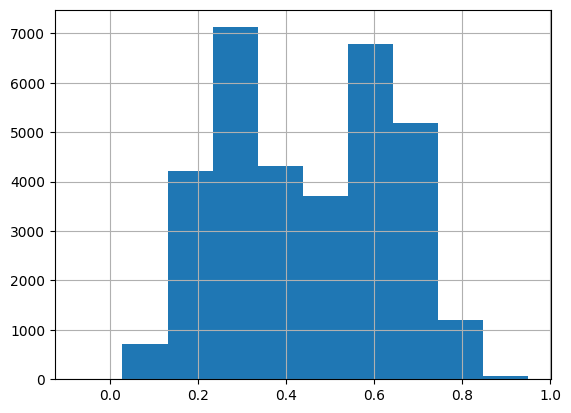

In [64]:
df['y'].hist() # Should be between 0 and 1, with some noise.

# CSV Creation

In [65]:
# Shuffle columns, keeping the target column at the end and ID at the beginning
cols = df.columns.tolist()
df = df[[cols[0]] + np.random.permutation(cols[1:-1]).tolist() + [cols[-1]]]

In [66]:
# Thematic renaming of columns
renaming = {
    ID_VARIABLE_NAME: 'LOCAL_IDENTIFIER',
    TARGET_VARIABLE_NAME: 'CORRUCYSTIC_DENSITY',

    'moon_1': 'v0rt3X',
    'moon_2': 'v1rt3X',
    'circle_1': 'r1Ng',
    'circle_2': 'r2Ng',
    'blob_1': 'b1oRb13',
    'blob_2': 'b2oRb13',

    'mindspike': 'MINDSPIKE',
}

generic_cols = [col for col in df.columns if col not in renaming]

import string

def random_gibberish(mean_length: int = 4, std_length = 3) -> str:
    length = max(3, int(round(random.gauss(mean_length, std_length))))
    chars = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choice(chars) for _ in range(length))

gibberish_mapping = {col: random_gibberish() for col in generic_cols}

final_mapping = {**renaming, **gibberish_mapping}

df.rename(columns=final_mapping, inplace=True)

In [67]:
N_PUBLIC_SAMPLES = int(N_SAMPLES * PUBLIC_LEADERBOARD_FRAC)
train = df.iloc[:N_TRAIN_SAMPLES]
public = df.iloc[N_TRAIN_SAMPLES:N_TRAIN_SAMPLES + N_PUBLIC_SAMPLES]
private = df.iloc[N_TRAIN_SAMPLES + N_PUBLIC_SAMPLES:]

In [68]:
# Populate NaNs
# WARNING: Renaming has taken place.

def add_nans(df: pd.DataFrame, prob, add_on_target: bool = False) -> pd.DataFrame:
    # Make some cells NaN with a given probability
    id = df[renaming[ID_VARIABLE_NAME]]
    df.drop(columns=[renaming[ID_VARIABLE_NAME]], inplace=True)
    if add_on_target:
        y = df[renaming[TARGET_VARIABLE_NAME]]
        df.drop(columns=[renaming[TARGET_VARIABLE_NAME]], inplace=True)
    
    n_cells = df.size
    n_nan = int(n_cells * prob)

    # Randomly choose pairs of indices
    nan_indices = (
        np.random.choice(df.index, n_nan, replace=True),
        np.random.choice(df.columns, n_nan, replace=True)
    )

    # Assign NaN
    for row, col in zip(*nan_indices):
        df.loc[row, col] = np.nan

    df = pd.concat([id, df], axis=1)  # Reattach the ID column
    if add_on_target:
        df[renaming[TARGET_VARIABLE_NAME]] = y # type: ignore
    return df

train = add_nans(train, prob=TRAIN_NAN_PROB, add_on_target=True)
public = add_nans(public, prob=PUBLIC_NAN_PROB, add_on_target=False)
private = add_nans(private, prob=PRIVATE_NAN_PROB, add_on_target=False)

C:\Users\arkma\AppData\Local\Temp\ipykernel_31108\3221987326.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[renaming[ID_VARIABLE_NAME]], inplace=True)
C:\Users\arkma\AppData\Local\Temp\ipykernel_31108\3221987326.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[renaming[TARGET_VARIABLE_NAME]], inplace=True)
C:\Users\arkma\AppData\Local\Temp\ipykernel_31108\3221987326.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [69]:
# Save the datasets to CSV files
from datetime import datetime
timestamp = datetime.now().strftime("%d_%H-%M-%S")

train.to_csv(f"{DATA_DIR}/{timestamp}_train.csv")
public.to_csv(f"{DATA_DIR}/{timestamp}_public.csv")
private.to_csv(f"{DATA_DIR}/{timestamp}_private.csv")